In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import head
import numpy as np
import matplotlib.pyplot as plt

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 75/75 dipoles valid


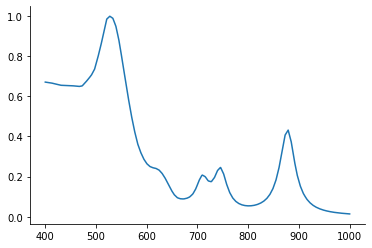

In [3]:
from pyGDM2 import (structures, materials, core, 
                    linear, fields, propagators, 
                    tools
                   )

def get_spectrum(l, r):
    """ Obtain a simulated absorption spectra for a hexagonal nanorod mesh
    L -- length of the cylinder
    R -- radius of the cylinder
    """
    step = 20
    geometry = structures.nanorod(step, L=l, R=r, mesh='hex')
    material = materials.gold()
    struct = structures.struct(step, geometry, material)
    field_generator = fields.plane_wave
    wavelengths = np.linspace(400, 1000, 100)
    kwargs = dict(theta=0, inc_angle=180)

    efield = fields.efield(field_generator,
                   wavelengths=wavelengths, kwargs=kwargs)
    n1 = n2 = 1.0
    dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)

    sim = core.simulation(struct, efield, dyads)
    sim.scatter(verbose=False)
    field_kwargs = tools.get_possible_field_params_spectra(sim)

    config_idx = 0
    wl, spectrum = tools.calculate_spectrum(sim,
                        field_kwargs[config_idx], linear.extinct)
    
    abs_ = spectrum.T[2]/np.max(spectrum.T[2])
    
    return head.UVVis(wl, abs_)


fd = get_spectrum(3, 2)
fd.plot()

In [4]:
# create a search space
# we create it using sqrt(L) and L/D by following this paper: 
# https://pubs.acs.org/action/showCitFormats?doi=10.1021/acs.jpcc.0c10680&ref=pdf

X = np.linspace(1,2, num=10) # sqrt(L)
Y = np.linspace(1,2, num=10) # l/D
grid = head.Euclidean(X,Y)

def get_params(p):
    L = p[1]**2
    R = 0.5*(L/p[0])
    
    return [L,R]

 c:\users\kiran vaddi\desktop\genetic_algorithm\head\designspace.py:9: FutureWarning:arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 31/31 dipoles valid
structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 159/159 dipoles valid


 C:\ProgramData\Anaconda3\lib\site-packages\pyGDM2\tools.py:907: UserWarning:Single dipole. Setting mesh to 'cubic'.


structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 1/1 dipoles valid
structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 93/93 dipoles valid


 C:\ProgramData\Anaconda3\lib\site-packages\pyGDM2\tools.py:907: UserWarning:Single dipole. Setting mesh to 'cubic'.


structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 1/1 dipoles valid
structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 31/31 dipoles valid
structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 17/17 dipoles valid


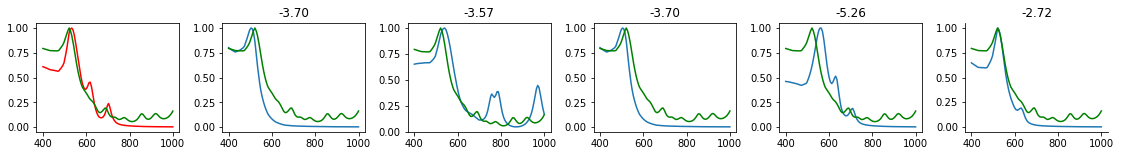

In [5]:
from modAL.models import BayesianOptimizer
import modAL
from skfda.misc.metrics import LpDistance
from sklearn.gaussian_process import GaussianProcessRegressor
from modAL.acquisition import max_EI

regressor = GaussianProcessRegressor()

def distance(query, target):
    d = LpDistance(p=2)
    
    return -d(query.fd, target.fd)

x0 = grid.sample()
p0 = get_params(x0)
# initialize with a random sample and corresponding spectrum
s0 = get_spectrum(p0[0],p0[1])
# define the target spectrum to be coming from a sphere of radius 3,3
pt = 3
st = get_spectrum(pt,pt)
y0 = distance(s0, st)

optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=x0.reshape(1, -1), y_training=y0,
    query_strategy=max_EI
)

# Bayesian optimization
loss_evol = []
loss_evol.append(y0)
fig, axs = plt.subplots(1,6,figsize=(2*6*1.6,2))
fig.subplots_adjust(wspace=0.3)
s0.plot(axs[0], color='red', label='initial')
st.plot(axs[0], color='green', label='target')
BUDGET = 5

for n_query in range(BUDGET):
    ax = axs[n_query+1]
    query_idx, query_inst = optimizer.query(grid.space)
    
    xi = grid[query_idx]
    pi = get_params(xi)
    si = get_spectrum(pi[0],pi[1])
    si.plot(ax, label='current selection')
    st.plot(ax, color='green')

    yi = distance(si, st)
    ax.set_title('{:.2f}'.format(yi[0]))
    loss_evol.append(yi)
    
    optimizer.teach(xi.reshape(1, -1), yi)

plt.show()

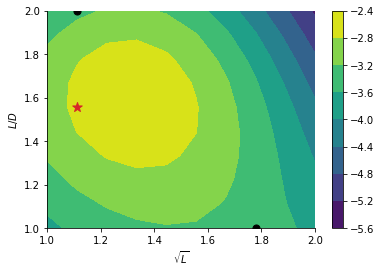

In [6]:
y_pred, y_std = optimizer.predict(grid.space, return_std=True)
X_max, y_max = optimizer.get_max()
fig, ax = plt.subplots()
im = ax.contourf(grid.mesh[0], grid.mesh[1], y_pred.reshape(10,10))
fig.colorbar(im, ax=ax)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel(r'$\sqrt{L}$')
ax.set_ylabel(r'$L/D$')
plt.scatter(optimizer.X_training[0], optimizer.X_training[1], c='k', s=50, label='Queried')
ax.scatter(X_max[0],X_max[1],color='tab:red',s=100,marker='*')
plt.show()